# Toxicity EDA: Understanding Label Distribution and Correlation

This EDA is focused on building a basic understanding of the data. What does it look like? What are the label distributions? How are different labels correlated with each other?

Some pieces of code were copied and/or inspired by another other great EDA: https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

In [3]:
# basics
import pandas as pd 
import numpy as np

# misc
import gc
import time
import warnings

# stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

# visualizations
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn

# nlp
import string
import re    # regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

# feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline

What does the data look like?

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


The training data consists of a comment_text (string) object and various types of BINARY toxicity labels. This is a key point, since our solutions will generate a probability DISTRIBUTION aimed at maximizing the ROC-AUC (or log-loss when it was the evaluation metric earlier in the competition).

There are almost 160,000 data points. A lot, but not a ton.

The labels are:  toxic, severe_toxic, obscene, threat, insult, and identity_hate.  Some of these labels seem to be objectively straightfoward to identify:  hate speech, insults, threats, and obscenities. But toxic and severe_toxic is a little grey and more subjective. What exactly is toxicity? What determines whether toxicity is severe? Why would something be labelled hate speech or insulting but not toxic? More on this later, when we examine the co-occurence matrices. 

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


The basic statistics show that approximately 10% of comments are toxic, 1% are sever toxic, 5% are obscene, 3% are threats, 5% are insults, and 1% are hate speech. Not only do each of the classes suffer from a data imbalance problem, but the degree of imbalance varies substantially between classes. This will be important to keep in mind when evaluating model performance, since it means the optimal "threshold" value when looking at recall curves, for example, will be different between the classes.

In [7]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The train and test distributions are similar in size, this is some good news at least.

In [8]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : Train : Test")
print("Rows   :",nrow_train,":",nrow_test)
print("Perc   :",round(nrow_train*100/sum),"    :",round(nrow_test*100/sum))

       : Train : Test
Rows   : 159571 : 153164
Perc   : 51     : 49


Approximately 22% of the comments have some sort of toxic label.

In [9]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


There aren't any missing values, that's a problem we don't have to worry about!

In [10]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


A plot of the label counts more clearly displays the degree of data imbalance.

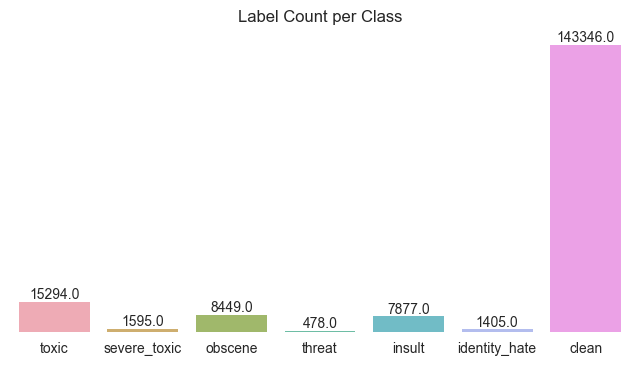

In [11]:
x=train.iloc[:,2:].sum()

fig = plt.figure(figsize=(8,4), dpi=100)
axes1 = fig.add_subplot(111);

sns.barplot(x.index, x.values, alpha=0.8, ax=axes1)
axes1.set_title("Label Count per Class")
#axes1.set_ylabel('Number of Occurrences', fontsize=12)
#axes1.set_xlabel('Class ', fontsize=12)

#adding the text labels
rects = axes1.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axes1.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

#axes1.set_ybound([0, 150000])
axes1.set_yticklabels([])
axes1.set_facecolor('white')

plt.show()

Around 16,000 comments, or 10%,  have multiple tags. This means that are likely to be correlations between classes, and the optimal models will not perform predictions on a strictly class-by-class basis. This does not matter "that much" for this competition, since the evaluation metric is mean column-wise ROC-AUC. In general however, especially if other evaluation metrics are used, it will matter.

Also, this means that probabilities do not have to add up to one. So we should use the softmax output in our neural nets, rather than sigmoid.

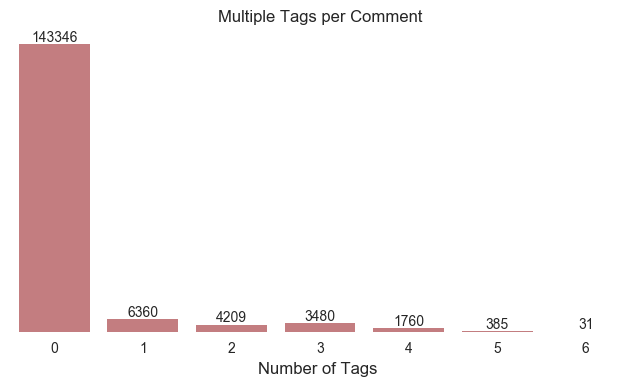

In [12]:
x=rowsums.value_counts()

fig = plt.figure(figsize=(8,4), dpi=100)
axes1 = fig.add_subplot(111);

sns.barplot(x.index, x.values, alpha=0.8,color=color[2], ax=axes1)
axes1.set_title("Multiple Tags per Comment")
#axes1.set_ylabel('Number of Occurrences', fontsize=12)
axes1.set_xlabel('Number of Tags ', fontsize=12)

#adding the text labels
rects = axes1.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    axes1.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

axes1.set_yticklabels([])
axes1.set_facecolor('white')

plt.show()

The Pearson correlation measures the linear correlation between two variables. Applied to non-continuous binary variables like those here, it is a measure of co-occurance.

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
http://algorithmic-worldview.blogspot.com/2009/01/co-occurrence-and-correlation.html

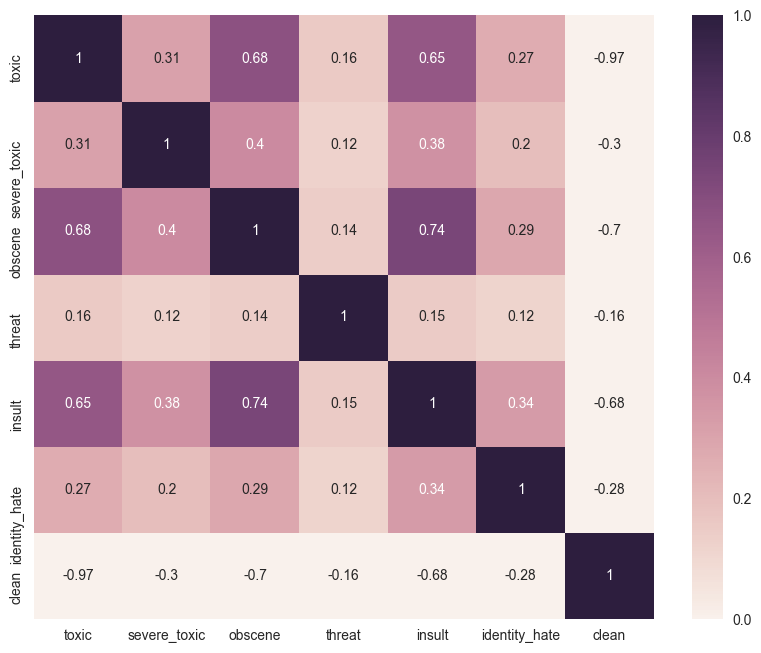

In [13]:
temp_df=train.iloc[:,2:]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()

fig = plt.figure(figsize=(10, 8), dpi=100)
axes1 = fig.add_subplot(111);

sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, ax=axes1, vmin=0, vmax=1)

Pearson correlation seems to imply relatively strong correlations between the class labeling. Let's take a more detail look at the beahvior by examining the cross-tabulation between the classes.

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html

In [14]:
# https://pandas.pydata.org/pandas-docs/stable/style.html
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

It looks like the high correlation values are dominated by 0-0 type co-occurances. If a value is marked not 'toxic' it will most likely not be marked with any other label. 

The actual number of 1-1 type occurances is rather small. Only in the case of 'obscene' and 'insult' is the co-occurance significant. If a value is marked 'toxic' it has an approximatley 50% chance of being marked 'obscene' or 'insulting'. 

Looking at it from the other direction, if a value is given a non-toxic label, it is very likely to be labelled toxic. All severe_toxic labels are also labelled toxic, thankfully, otherwise we'd have a serious data labelling problem on our hands. However, it is a slight concern that there do exist unclean non-toxic labels. Some clarification on Jigsaw's labeling methodology would be nice (or perhaps this is an example of how Jigsaw can improve their methodology).

In [15]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
keys=np.delete(temp_df.columns.values, 0)
for other_col in keys:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats, axis=1, keys=keys)

#cell highlighting
out = out.style.apply(highlight_min, axis=0)
out

Of the comment labelled as "toxic", about 12% are also labelled "severe_toxic". We could view this as another modeling challenge in and of itself. We also see that of the comments labelled "severe_toxic"  around 22% to 30% have other labels.

In [16]:
main_col="severe_toxic"
corr_mats=[]
keys=np.delete(temp_df.columns.values, 1)
for other_col in keys:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats, axis=1, keys=keys)
out = out.style.apply(highlight_min,axis=0)
out

Obscene labels have around a 50% chance of being labeled toxic, but only a 5% chance of being labelled severe_toxic.

In [17]:
main_col="obscene"
corr_mats=[]
keys=np.delete(temp_df.columns.values, 2)
for other_col in keys:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats, axis=1, keys=keys)
out = out.style.apply(highlight_min,axis=0)
out

Ah the threat column, one of the most misbehaved labels in the classifiers we'll develop. The cross tabulation shows that a comment labeled as a threat has a very low chance of being given another label. This, in combination with the relatively small number of samples (only 478!), may explain why it will end up being the most difficult label to predict.

In [18]:
main_col="threat"
corr_mats=[]
keys=np.delete(temp_df.columns.values, 3)
for other_col in keys:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats, axis=1, keys=keys)
out = out.style.apply(highlight_min,axis=0)
out

Although insults are only about 50-50 with toxic, they are highly correlated with every other label. 

In [19]:
main_col="insult"
corr_mats=[]
keys=np.delete(temp_df.columns.values, 4)
for other_col in keys:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats, axis=1, keys=keys)
out = out.style.apply(highlight_min,axis=0)
out

Likewise, if a comment is labeled 'identity hate' it has a very strong chance of being labeled 'toxic', 'obscene', and 'insulting'. This doesn't seem to be represented very well in the Pearson correlation however.

In [20]:
main_col="identity_hate"
corr_mats=[]
keys=np.delete(temp_df.columns.values, 5)
for other_col in keys:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats, axis=1, keys=keys)
out = out.style.apply(highlight_min,axis=0)
out